## ECN Spider data input

First, load prerequisites and configure things

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import bz2
from ipaddress import ip_address

# Change this to point at the raw data files (they're not in the paper directory)
#DATAPATH="/Users/brian/work/ecn" # for thaleia

DATAPATH="." # for maloja
TABLESDIR="."
PLOTSDIR="."

Load the `cc_df` (ECN Spider) table, which has the following columns:

- `ip`: index, IP address as string
- `rank`: Alexa website rank
- `site`: Website hostname
- `ip6`: True if address is IPv6 (for convenience in splitting v4 and v6 analyses without string munging)
- *vantage*`-`*trial*`-e0`: True if connection succeeded for *trial* at *vantage* without ECN negotiation attempt
- *vantage*`-`*trial*`-e1`: True if connection succeeded for *trial* at *vantage* with ECN negotiation attempt


In [2]:
cc_df = pd.read_csv(TABLESDIR+"/cc_df.csv")
cc_df.index = cc_df["ip"]
del cc_df["ip"]

Derive some convenience columns from the raw data:

- *vantage*`-`*trial*`-nope`: True if connection always failed
- *vantage*`-`*trial*`-eq`: True if connection state is equal for ECN and no-ECN
- *vantage*`-`*trial*`-dep`: True if connection without ECN, not with.
- *vantage*`-`*trial*`-odd`: True if connection with ECN, not without.

In [3]:
e0cols = []
e1cols = []
nopecols = []
eqcols = []
depcols = []
oddcols = []

# Per-trial additional data
for vp in ["ams"]:
    for trial in [0]:
        trial = str(trial)
        e0col = "-".join([vp,trial,"e0"])
        e1col = "-".join([vp,trial,"e1"])
        nopecol = "-".join([vp,trial,"nope"])
        eqcol = "-".join([vp,trial,"eq"])
        depcol = "-".join([vp,trial,"dep"])
        oddcol = "-".join([vp,trial,"odd"])
        e0cols += [e0col]
        e1cols += [e1col]
        nopecols += [nopecol]
        eqcols += [eqcol]
        depcols += [depcol]       
        oddcols += [oddcol]        
        
        cc_df[nopecol] = (~cc_df[e0col] & ~cc_df[e1col])
        cc_df[eqcol] = (cc_df[e0col] & cc_df[e1col]) | cc_df[nopecol]
        cc_df[depcol] = cc_df[e0col] & ~cc_df[e1col]
        cc_df[oddcol] = ~cc_df[e0col] & cc_df[e1col]

Now generate connectivity dependency numbers:

In [4]:
ip4conndep = cc_df[~cc_df['ip6']]['ams-0-dep'].value_counts()[True]
ip4total = len(cc_df[~cc_df['ip6']])
print("%6u of %6u (%5.3f%%) of IPv4 addresses may have ECN dependency"%(ip4conndep, 
                                                                      ip4total, 
                                                                      ip4conndep * 100 / ip4total))
ip6conndep = cc_df[cc_df['ip6']]['ams-0-dep'].value_counts()[True]
ip6total = len(cc_df[cc_df['ip6']])
print("%6u of %6u (%5.3f%%) of IPv6 addresses may have ECN dependency"%(ip6conndep, 
                                                                      ip6total, 
                                                                      ip6conndep * 100 / ip6total))
print("%6u of %6u (%5.3f%%) of  all addresses may have ECN dependency"%(ip4conndep + ip6conndep, 
                                                                      ip4total + ip6total, 
                                                                      (ip4conndep + ip6conndep) * 100 / (ip4total + ip6total)))



  2809 of 628896 (0.447%) of IPv4 addresses may have ECN dependency
    30 of  26393 (0.114%) of IPv6 addresses may have ECN dependency
  2839 of 655289 (0.433%) of  all addresses may have ECN dependency


How about complete connection failure?

In [5]:
ip4nope = cc_df[~cc_df['ip6']]['ams-0-nope'].value_counts()[True]
print("%6u of %6u (%5.3f%%) of IPv4 addresses failed to connect"%(ip4nope, 
                                                                      ip4total, 
                                                                      ip4nope * 100 / ip4total))
ip6nope = cc_df[cc_df['ip6']]['ams-0-nope'].value_counts()[True]
print("%6u of %6u (%5.3f%%) of IPv6 addresses failed to connect"%(ip6nope, 
                                                                      ip6total, 
                                                                      ip6nope * 100 / ip6total))
print("%6u of %6u (%5.3f%%) of  all addresses failed to connect"%(ip4nope + ip6nope, 
                                                                      ip4total + ip6total, 
                                                                      (ip4nope + ip6nope) * 100 / (ip4total + ip6total)))




  9221 of 628896 (1.466%) of IPv4 addresses failed to connect
  2637 of  26393 (9.991%) of IPv6 addresses failed to connect
 11858 of 655289 (1.810%) of  all addresses failed to connect


Now we can plot dependency by rank

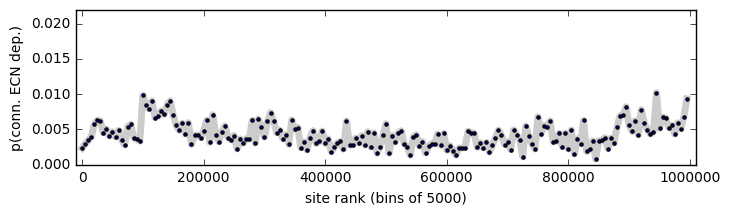

In [6]:
dep_df = cc_df.loc[:,["rank","ams-0-dep"]]
dep_df.columns = ["rank","conndep"]

dep_grp = dep_df.groupby(np.digitize(dep_df["rank"], np.linspace(0,1000000,201)))
dep_ser = (dep_grp["conndep"].sum() / dep_grp["rank"].count())
dep_ser.index = (dep_ser.index + (-1)) * 5000

plt.figure(figsize=(8,2))
plt.scatter(dep_ser.index, dep_ser, marker=".")
plt.plot(dep_ser.index, dep_ser, c="k", lw=5, alpha=0.20)
plt.xlim(-10000,1010000)
plt.ylim(0,0.022)
plt.ylabel("p(conn. ECN dep.)")
plt.xlabel("site rank (bins of 5000)")
plt.savefig(PLOTSDIR+"/connrank.pdf", bbox_inches="tight")

# QoF Data Input

Load the `qq_df` table, which has the following columns:

- `ip`: index, IP address as string
- `rank`: Alexa website rank
- `site`: Website hostname
- `ip6`: True if address is IPv6 (for convenience in splitting v4 and v6 analyses without string munging)
- *vantage*`-`*trial*`-e0`: True if connection established for *trial* at *vantage* without ECN negotiation attempt
- *vantage*`-`*trial*`-e0ect0`: True if non-ECN flow set ECT0 flag on downstream for *trial* at *vantage*
- *vantage*`-`*trial*`-e0ect1`: True if non-ECN flow set ECT1 flag on downstream for *trial* at *vantage*
- *vantage*`-`*trial*`-e0ce`: True if non-ECN flow set CE flag on downstream for *trial* at *vantage*
- *vantage*`-`*trial*`-e0f`: Flags on last SYN of upstream non-ECN flow for *trial* at *vantage*
- *vantage*`-`*trial*`-e0rf`: Flags on last SYN of downstream non-ECN flow for *trial* at *vantage*
- *vantage*`-`*trial*`-e0ruf`: Union flags on downstream non-ECN flow for *trial* at *vantage*
- *vantage*`-`*trial*`-ttl`: Max TTL received on downstream non-ECN flow for *trial* at *vantage*
- *vantage*`-`*trial*`-z0`: True if no payload received for non-ECN flow for *trial* at *vantage*
- *vantage*`-`*trial*`-z1`: True if no payload received for ECN flow for *trial* at *vantage*
- *vantage*`-`*trial*`-e1`: True if connection established for *trial* at *vantage* with ECN negotiation attempt
- *vantage*`-`*trial*`-neg`: True if ECN negotiated for *trial* at *vantage*
- *vantage*`-`*trial*`-ect0`: True if ECN flow set ECT0 flag on downstream for *trial* at *vantage*
- *vantage*`-`*trial*`-ect1`: True if ECN flow set ECT1 flag on downstream for *trial* at *vantage*
- *vantage*`-`*trial*`-ce`: True if ECN flow set CE flag on downstream for *trial* at *vantage*
- *vantage*`-`*trial*`-synect0`: True if ECN flow set ECT0 flag on downstream SYN ACK for *trial* at *vantage*
- *vantage*`-`*trial*`-synect1`: True if ECN flow set ECT1 flag on downstream SYN ACK for *trial* at *vantage*
- *vantage*`-`*trial*`-synce`: True if ECN flow set CE flag on downstream SYN ACK for *trial* at *vantage*
- *vantage*`-`*trial*`-refl`: True if ECN TCP flags were reflected (SEW -> SAEW) for *trial* at *vantage*
- *vantage*`-`*trial*`-ect`: True if ECT0 or ECT1 set on downstream ECN flow for *trial* at *vantage*
- *vantage*`-`*trial*`-negok`: True if negotiation succeeded (resulted in ECT marking) for  *trial* at *vantage*

The `-sum` columns for each of the boolean columns above simply count True values across all trials and vantage points.

In [7]:
qq_df = pd.read_csv(TABLESDIR+"/qq_df.csv")
qq_df.index = qq_df["ip"]
del qq_df["ip"]

Headline numbers: how many negotiate ECN?

In [8]:
ip4neg = qq_df[~qq_df['ip6']]['neg-sum'].sum()
ip4total = len(qq_df[~qq_df['ip6']])
print("%6u of %6u (%5.3f%%) of IPv4 addresses negotiate ECN"%(ip4neg, 
                                                              ip4total, 
                                                              ip4neg * 100 / ip4total))
ip6neg = qq_df[qq_df['ip6']]['neg-sum'].sum()
ip6total = len(qq_df[qq_df['ip6']])
print("%6u of %6u (%5.3f%%) of IPv6 addresses negotiate ECN"%(ip6neg, 
                                                              ip6total, 
                                                              ip6neg * 100 / ip6total))
print("%6u of %6u (%5.3f%%) of  all addresses negotiate ECN"%(ip4neg + ip6neg, 
                                                                      ip4total + ip6total, 
                                                                      (ip4neg + ip6neg) * 100 / (ip4total + ip6total)))




432544 of 617873 (70.005%) of IPv4 addresses negotiate ECN
 20262 of  24472 (82.797%) of IPv6 addresses negotiate ECN
452806 of 642345 (70.493%) of  all addresses negotiate ECN


Sieve the resulting rows

In [9]:
# First throw away things that never connect with ECN
qq_df_nc =        qq_df[qq_df['e1-sum'] == 0]
qq_df_c =         qq_df[qq_df['e1-sum'] > 0]

# Anything we've ever seen a negotiation from counts as ECN-capable
qq_df_ecn =       qq_df_c[qq_df_c['neg-sum'] > 0]

# Then sieve out those things which always negotiate when they connect
qq_df_ecnall =    qq_df_ecn[qq_df_ecn['e1-sum'] - qq_df_ecn['neg-sum'] == 0]
qq_df_ecnsome =   qq_df_ecn[qq_df_ecn['e1-sum'] - qq_df_ecn['neg-sum'] != 0]

# Then sieve out things where we don't see data, but we always do with ECN
# This case, as it turns out, is not really interesting
# qq_df_ecnzl =     qq_df_ecnall[(qq_df_ecnall['zl-sum'] - qq_df_ecnall['e1-sum'] == 0) &
#                                (qq_df_ecnall['0zl-sum'] - qq_df_ecnall['e1-sum'] >= 0)]

# Then sieve out those things which also always or never mark when they negotiate
qq_df_ecnmark =   qq_df_ecnall[qq_df_ecnall['neg-sum'] - qq_df_ecnall['negok-sum'] == 0]
# For never mark, don't include things that don't mark because we see no data
qq_df_ecnnomark = qq_df_ecnall[(qq_df_ecnall['negok-sum'] == 0) & (qq_df_ecnall['z1-sum'] == 0)]

# Now look at those things which never negotiate
qq_df_noecn =     qq_df_c[qq_df_c['neg-sum'] == 0]
qq_df_noecnrefl = qq_df_noecn[qq_df_noecn['refl-sum'] - qq_df_noecn['e1-sum'] == 0]
qq_df_noecnect0 = qq_df_noecn[qq_df_noecn['ect0-sum'] - qq_df_noecn['e1-sum'] == 0]
qq_df_noecnect1 = qq_df_noecn[qq_df_noecn['ect1-sum'] - qq_df_noecn['e1-sum'] == 0]
qq_df_noecnce  =  qq_df_noecn[qq_df_noecn['ce-sum'] - qq_df_noecn['e1-sum'] == 0]


And build a table, like the one in the PAM 2015 paper

In [10]:
def df4(df):
    return df[~df['ip6']]

def df6(df):
    return df[ df['ip6']]

# Now build a table
qip4all_ct =        len(df4(qq_df))
qip4nc_ct =         len(df4(qq_df_nc))
qip4ecn_ct =        len(df4(qq_df_ecn))
qip4ecnall_ct =     len(df4(qq_df_ecnall))
#qip4ecnzl_ct =      len(df4(qq_df_ecnzl))
qip4ecnmark_ct =    len(df4(qq_df_ecnmark))
qip4ecnnomark_ct =  len(df4(qq_df_ecnnomark))
qip4someecn_ct =    len(df4(qq_df_ecnsome))
#qip4pathnego_ct =   len(df4(qq_df_pathnego))
qip4noecn_ct =      len(df4(qq_df_noecn))
qip4noecnect0_ct =  len(df4(qq_df_noecnect0))
qip4noecnect1_ct =  len(df4(qq_df_noecnect1))
qip4noecnce_ct =    len(df4(qq_df_noecnce))
qip4noecnrefl_ct =    len(df4(qq_df_noecnrefl))

qip6all_ct =        len(df6(qq_df))
qip6nc_ct =         len(df6(qq_df_nc))
qip6ecn_ct =        len(df6(qq_df_ecn))
qip6ecnall_ct =     len(df6(qq_df_ecnall))
#qip6ecnzl_ct =      len(df6(qq_df_ecnzl))
qip6ecnmark_ct =    len(df6(qq_df_ecnmark))
qip6ecnnomark_ct =  len(df6(qq_df_ecnnomark))
qip6someecn_ct =    len(df6(qq_df_ecnsome))
#qip6pathnego_ct =   len(df6(qq_df_pathnego))
qip6noecn_ct =      len(df6(qq_df_noecn))
qip6noecnect0_ct =  len(df6(qq_df_noecnect0))
qip6noecnect1_ct =  len(df6(qq_df_noecnect1))
qip6noecnce_ct =    len(df6(qq_df_noecnce))
qip6noecnrefl_ct =    len(df6(qq_df_noecnrefl))

def print_tablerow(ct4, ct6, ct4a, ct6a, label):
    print("%6u & %5.2f\%% & %5u & %5.2f\%% & %s\\\\" %
        (ct4, ct4*100/ct4a, ct6, ct6*100/ct6a, label))

#print_tablerow(qip4all_ct,     qip6all_ct,     qip4all_ct, qip6all_ct, "Capable of connecting with ECN")
print_tablerow(qip4ecn_ct,     qip6ecn_ct,     qip4all_ct, qip6all_ct, "Capable of negotiating ECN, of which...")
#print_tablerow(qip4ecnall_ct,  qip6ecnall_ct,  qip4all_ct, qip6all_ct,   "\\hspace{1em} Always negotiate, of which...")
#print_tablerow(qip4ecnmark_ct, qip6ecnmark_ct, qip4all_ct, qip6all_ct,     "\\hspace{2em} Always mark ECT(0)")
print_tablerow(qip4ecnnomark_ct, qip6ecnnomark_ct, qip4all_ct, qip6all_ct, "\\hspace{2em} Never mark ECT")
#print_tablerow(qip4ecnzl_ct,     qip6ecnzl_ct, qip4all_ct, qip6all_ct,     "\\hspace{2em} Never send data")
#print_tablerow(qip4someecn_ct,  qip6someecn_ct,  qip4all_ct, qip6all_ct,   "\\hspace{1em} Sometimes negotiate, of which...")
#print_tablerow(qip4pathnego_ct,  qip6pathnego_ct,  qip4all_ct, qip6all_ct,   "\\hspace{2em} Negotiation depends on path")
print_tablerow(qip4noecn_ct,  qip6noecn_ct,  qip4all_ct, qip6all_ct, "Not capable of negotiating ECN, of which...")
print_tablerow(qip4noecnect0_ct,  qip6noecnect0_ct,  qip4all_ct, qip6all_ct,   "\\hspace{1em} Always mark ECT(0)")
#print_tablerow(qip4noecnect1_ct,  qip6noecnect1_ct,  qip4all_ct, qip6all_ct,   "\\hspace{1em} Always mark ECT(1)")
#print_tablerow(qip4noecnce_ct,    qip6noecnce_ct,  qip4all_ct, qip6all_ct,     "\\hspace{1em} Always mark CE")
#print_tablerow(qip4noecnrefl_ct,  qip6noecnrefl_ct,  qip4all_ct, qip6all_ct,   "\\hspace{1em} Always reflect ECN flags")
print_tablerow(qip4nc_ct,  qip6nc_ct,  qip4all_ct, qip6all_ct, "Never connect with ECN")


432544 & 70.01\% & 20262 & 82.80\% & Capable of negotiating ECN, of which...\\
 11718 &  1.90\% &  2167 &  8.86\% & \hspace{2em} Never mark ECT\\
184217 & 29.81\% &  3246 & 13.26\% & Not capable of negotiating ECN, of which...\\
   689 &  0.11\% &    28 &  0.11\% & \hspace{1em} Always mark ECT(0)\\
  1112 &  0.18\% &   964 &  3.94\% & Never connect with ECN\\


Build the negotiation/marking matrix (Table 3)

In [11]:
# Bigger negotiation/marking matrix

def has_data(df):
    return df[(df["e1-sum"] - df["z1-sum"]) > 0]

qq_df_ecnall_nzl =   has_data(qq_df_ecnall)
qq_df_anyrefl =      has_data(qq_df_c[qq_df_c["refl-sum"] > 0])
qq_df_noecn_norefl = has_data(qq_df_noecn[qq_df_noecn["refl-sum"] == 0])

def matrix_col(df, df46):
    e0 =  len(df46(df[(df["ect0-sum"]  > 0) & (df["ect1-sum"] == 0) & (df["ce-sum"] == 0)]))
    e1 =  len(df46(df[(df["ect0-sum"] == 0) & (df["ect1-sum"]  > 0) & (df["ce-sum"] == 0)]))
    ce =  len(df46(df[(df["ect0-sum"] == 0) & (df["ect1-sum"] == 0) & (df["ce-sum"]  > 0)]))
    e01 = len(df46(df[(df["ect0-sum"]  > 0) & (df["ect1-sum"]  > 0) & (df["ce-sum"] == 0)]))
    c01 = len(df46(df[(df["ect0-sum"]       +  df["ect1-sum"]  > 0) & (df["ce-sum"]  > 0)]))
    nm =  len(df46(df[(df["ect0-sum"] == 0) & (df["ect1-sum"] == 0) & (df["ce-sum"] == 0)]))
    return (e0, e1, ce, e01, c01, nm)

def matrix_col_syn(df, df46):
    e0 =  len(df46(df[(df["synect0-sum"] > 0)]))
    e1 =  len(df46(df[(df["synect1-sum"] > 0)]))
    ce =  len(df46(df[(df["synce-sum"] > 0)]))
    return (e0, e1, ce)

def matrix_col_allmark(df, df46):
    e0 =  len(df46(df[(df["ect0-sum"] - df['e1-sum'] == 0) & 
                      (df["ect1-sum"] == 0) & 
                      (df["ce-sum"] == 0)]))
    e1 =  len(df46(df[(df["ect0-sum"] == 0) & 
                      (df["ect1-sum"] - df['e1-sum'] == 0) & 
                      (df["ce-sum"] == 0)]))
    ce =  len(df46(df[(df["ect0-sum"] == 0) & 
                      (df["ect1-sum"] == 0) &
                      (df["ce-sum"] - df['e1-sum'] == 0)]))
    e01 = len(df46(df[(df["ect0-sum"] - df['e1-sum'] == 0) & 
                      (df["ect1-sum"] - df['e1-sum'] == 0) & 
                      (df["ce-sum"] == 0)]))
    c01 = len(df46(df[(df["ect0-sum"] + df["ect1-sum"] - df['e1-sum'] == 0) 
                      & (df["ce-sum"]  > 0)]))
    return (e0, e1, ce, e01, c01)


(mat4_ne0, mat4_ne1, mat4_nce, mat4_ne01, mat4_nc01, mat4_nnm) = matrix_col(qq_df_ecnall_nzl,   df4)
(mat4_re0, mat4_re1, mat4_rce, mat4_re01, mat4_rc01, mat4_rnm) = matrix_col(qq_df_anyrefl,      df4)
(mat4_xe0, mat4_xe1, mat4_xce, mat4_xe01, mat4_xc01, mat4_xnm) = matrix_col(qq_df_noecn_norefl, df4)

(mat6_ne0, mat6_ne1, mat6_nce, mat6_ne01, mat6_nc01, mat6_nnm) = matrix_col(qq_df_ecnall_nzl,   df6)
(mat6_re0, mat6_re1, mat6_rce, mat6_re01, mat6_rc01, mat6_rnm) = matrix_col(qq_df_anyrefl,      df6)
(mat6_xe0, mat6_xe1, mat6_xce, mat6_xe01, mat6_xc01, mat6_xnm) = matrix_col(qq_df_noecn_norefl, df6)

(mat4_ane0, mat4_ane1, mat4_ance, mat4_ane01, mat4_anc01) = matrix_col_allmark(qq_df_ecnall_nzl,   df4)
(mat4_are0, mat4_are1, mat4_arce, mat4_are01, mat4_arc01) = matrix_col_allmark(qq_df_anyrefl,      df4)
(mat4_axe0, mat4_axe1, mat4_axce, mat4_axe01, mat4_axc01) = matrix_col_allmark(qq_df_noecn_norefl, df4)

(mat6_ane0, mat6_ane1, mat6_ance, mat6_ane01, mat6_anc01) = matrix_col_allmark(qq_df_ecnall_nzl,   df6)
(mat6_are0, mat6_are1, mat6_arce, mat6_are01, mat6_arc01) = matrix_col_allmark(qq_df_anyrefl,      df6)
(mat6_axe0, mat6_axe1, mat6_axce, mat6_axe01, mat6_axc01) = matrix_col_allmark(qq_df_noecn_norefl, df6)

(mat4_sne0, mat4_sne1, mat4_snce) = matrix_col_syn(qq_df_ecnall_nzl,   df4)
(mat4_sre0, mat4_sre1, mat4_srce) = matrix_col_syn(qq_df_anyrefl,      df4)
(mat4_sxe0, mat4_sxe1, mat4_sxce) = matrix_col_syn(qq_df_noecn_norefl, df4)

(mat6_sne0, mat6_sne1, mat6_snce) = matrix_col_syn(qq_df_ecnall_nzl,   df6)
(mat6_sre0, mat6_sre1, mat6_srce) = matrix_col_syn(qq_df_anyrefl,      df6)
(mat6_sxe0, mat6_sxe1, mat6_sxce) = matrix_col_syn(qq_df_noecn_norefl, df6)


print("\\begin{tabular}{ r | r  r  r | r r r }")
print("        & \\multicolumn{3}{c|}{IPv4 (N=%u)} & \\multicolumn{3}{c}{IPv6 (N=%u)} \\\\" %
      (len(df4(qq_df)), len(df6(qq_df))))
print("Marking                  & ECN   & Reflect & No ECN & ECN   & Reflect & No ECN\\\\")
print("\hline")
print("only \ectzero            & %6u & %6u & %6u & %6u & %6u & %6u \\\\" %
      (mat4_ne0, mat4_re0, mat4_xe0, mat6_ne0, mat6_re0, mat6_xe0))
print("\ectzero  + \ectone & %6u & %6u & %6u & %6u & %6u & %6u \\\\" %
      (mat4_ne01, mat4_re01, mat4_xe01, mat6_ne01, mat6_re01, mat6_xe01))
print("\hline")
print("\ectzero on \syncack & %6u & %6u & %6u & %6u & %6u & %6u \\\\" %
      (mat4_sne0, mat4_sre0, mat4_sxe0, mat6_sne0, mat6_sre0, mat6_sxe0))
print("\hline \hline")
print("only \ectone         & %6u & %6u & %6u & %6u & %6u & %6u \\\\"%
      (mat4_ne1, mat4_re1, mat4_xe1, mat6_ne1, mat6_re1, mat6_xe1))
print("\hline")
print("\ectone on \synack      & %6u & %6u & %6u & %6u & %6u & %6u \\\\" %
      (mat4_sne1, mat4_sre1, mat4_sxe1, mat6_sne1, mat6_sre1, mat6_sxe1))
print("\hline \hline")
print("only \ce               & %6u & %6u & %6u & %6u & %6u & %6u \\\\"%
      (mat4_nce, mat4_rce, mat4_xce, mat6_nce, mat6_rce, mat6_xce))
print("\ce + \ect   & %6u & %6u & %6u & %6u & %6u & %6u \\\\"%
      (mat4_nc01, mat4_rc01, mat4_xc01, mat6_nc01, mat6_rc01, mat6_xc01))
print("\hline")
print("\ce on \synack & %6u & %6u & %6u & %6u & %6u & %6u \\\\" %
      (mat4_snce, mat4_srce, mat4_sxce, mat6_snce, mat6_srce, mat6_sxce))
print("\hline \hline")
print("none                     & %6u & %6u & %6u & %6u & %6u & %6u \\\\"%
      (mat4_nnm, mat4_rnm, mat4_xnm, mat6_nnm, mat6_rnm, mat6_xnm))

print("\end{tabular}")
print()
print ("%5.2f%% IPv4 negotiation anomalies" % 
       (100*(1 - ((mat4_ne0 + mat4_xnm) / sum ((mat4_ne0, mat4_ne1, mat4_nce, mat4_ne01, mat4_nc01, mat4_nnm,
                                           mat4_re0, mat4_re1, mat4_rce, mat4_re01, mat4_rc01, mat4_rnm,
                                           mat4_xe0, mat4_xe1, mat4_xce, mat4_xe01, mat4_xc01, mat4_xnm))))))
print ("%5.2f%% IPv6 negotiation anomalies" % 
       (100*(1 - ((mat6_ne0 + mat6_xnm) / sum ((mat6_ne0, mat6_ne1, mat6_nce, mat6_ne01, mat6_nc01, mat6_nnm,
                                           mat6_re0, mat6_re1, mat6_rce, mat6_re01, mat6_rc01, mat6_rnm,
                                           mat6_xe0, mat6_xe1, mat6_xce, mat6_xe01, mat6_xc01, mat6_xnm))))))


\begin{tabular}{ r | r  r  r | r r r }
        & \multicolumn{3}{c|}{IPv4 (N=617873)} & \multicolumn{3}{c}{IPv6 (N=24472)} \\
Marking                  & ECN   & Reflect & No ECN & ECN   & Reflect & No ECN\\
\hline
only \ectzero            & 418979 &    208 &    480 &  17968 &      1 &     27 \\
\ectzero  + \ectone &      0 &      0 &      0 &      0 &      0 &      0 \\
\hline
\ectzero on \syncack &  24145 &      0 &     11 &    397 &      0 &     27 \\
\hline \hline
only \ectone         &     16 &      0 &      8 &      0 &     36 &     14 \\
\hline
\ectone on \synack      &     19 &      0 &      8 &      0 &      0 &      9 \\
\hline \hline
only \ce               &     17 &      0 &      3 &      0 &      0 &     17 \\
\ce + \ect   &      6 &      0 &      0 &      0 &     23 &      0 \\
\hline
\ce on \synack &     10 &      0 &      3 &      0 &      0 &     17 \\
\hline \hline
none                     &  11701 &   2250 & 180221 &   2167 &      7 &   3104 \\
\end{tabular}

 2.39% I

Now look at ECN capability resieved only for TTL64 (Linux) hosts

In [12]:
# Resieve again for Linux
qq_df_linttl = qq_df_c[(qq_df_c['ams-0-ttl'] > 32 ) & (qq_df_c['ams-0-ttl'] < 64)]
qq_df_linecn = qq_df_linttl[qq_df_linttl['neg-sum'] > 0]

print ("considering only initial-TTL 64 hosts, %u of %u or %5.2f\%% are ECN capable" % (
        len(qq_df_linecn), len(qq_df_linttl), 100*len(qq_df_linecn)/len(qq_df_linttl)))

considering only initial-TTL 64 hosts, 420371 of 514703 or 81.67\% are ECN capable


Print rank spectrum for negotiation

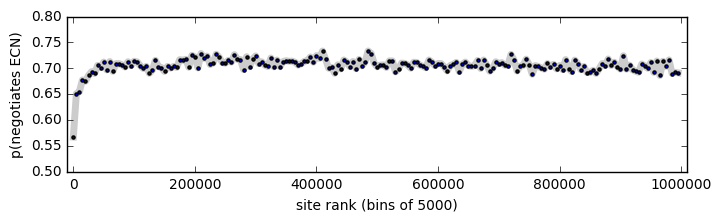

In [13]:
qq_df["nego"] = qq_df["neg-sum"] > 0

# Negotiation rank spectrum
grp = qq_df.groupby(np.digitize(qq_df["rank"], np.linspace(0,1000000,201)))
ser = (grp["nego"].sum() / grp["rank"].count())
ser.index = (ser.index + (-1)) * 5000

plt.figure(figsize=(8,2))
plt.scatter(ser.index, ser, marker=".")
plt.plot(ser.index, ser, c="k", lw=5, alpha=0.20)
plt.xlim(-10000,1010000)
plt.ylabel("p(negotiates ECN)")
plt.xlabel("site rank (bins of 5000)")
plt.savefig(PLOTSDIR+"/negorank.pdf", bbox_inches="tight")

Marking anomalies: look at markings on non-ECN-negotiated (Table 4)

In [14]:
def e0mark_counts(df, df46, col):
    many = len(df46(df[(df["e0"+col+"-sum"] > 0) & (df["e0-sum"] > 0)]))
    mall = len(df46(df[(df["e0"+col+"-sum"] == df["e0-sum"]) & (df["e0-sum"] > 0)]))
    msyn = len(df46(df[(df["e0syn"+col+"-sum"] > 0) & (df["e0-sum"] > 0)]))
    return (many, mall, msyn)

(m4e0e0, a4e0e0, s4e0e0) = e0mark_counts(qq_df, df4, "ect0")
(m6e0e0, a6e0e0, s6e0e0) = e0mark_counts(qq_df, df6, "ect0")
(m4e0e1, a4e0e1, s4e0e1) = e0mark_counts(qq_df, df4, "ect1")
(m6e0e1, a6e0e1, s6e0e1) = e0mark_counts(qq_df, df6, "ect1")
(m4e0ce, a4e0ce, s4e0ce) = e0mark_counts(qq_df, df4, "ce")
(m6e0ce, a6e0ce, s6e0ce) = e0mark_counts(qq_df, df6, "ce")

print("\\begin{tabular}{ r | r  r  r | r r r }")
print("        & \\multicolumn{3}{c|}{IPv4 (N=%u)} & \\multicolumn{3}{c}{IPv6 (N=%u)} \\\\" %
      (len(df4(qq_df)), len(df6(qq_df))))
print("Codepoint                & Once & Always & \synack & Once & Always & \synack \\\\")
print("\hline")
print("\ectzero                & %6u & %6u & %6u & %6u & %6u & %6u \\\\" %
      (m4e0e0, a4e0e0, s4e0e0, m6e0e0, a6e0e0, s6e0e0))
print("\ectone               & %6u & %6u & %6u & %6u & %6u & %6u \\\\" %
      (m4e0e1, a4e0e1, s4e0e1, m6e0e1, a6e0e1, s6e0e1))
print("\ce                    & %6u & %6u & %6u & %6u & %6u & %6u \\\\" %
      (m4e0ce, a4e0ce, s4e0ce, m6e0ce, a6e0ce, s6e0ce))


\begin{tabular}{ r | r  r  r | r r r }
        & \multicolumn{3}{c|}{IPv4 (N=617873)} & \multicolumn{3}{c}{IPv6 (N=24472)} \\
Codepoint                & Once & Always & \synack & Once & Always & \synack \\
\hline
\ectzero                &    285 &    285 &     16 &     22 &     22 &     21 \\
\ectone               &     14 &     14 &     14 &     66 &     66 &      2 \\
\ce                    &     13 &     13 &     13 &     41 &     41 &     16 \\


A few more anecdotes:

In [15]:
print("%u IPv4 and %u IPv6 mark CE when not negotiating ECN; %u IPv4 and %u IPv6 on every flow" % (
    len(df4(qq_df[(qq_df["e0ce-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0ce-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df4(qq_df[(qq_df["e0ce-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0ce-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    ))
print("%u IPv4 and %u IPv6 mark ECT0 when not negotiating ECN; %u IPv4 and %u IPv6 on every flow" % (
    len(df4(qq_df[(qq_df["e0ect0-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0ect0-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df4(qq_df[(qq_df["e0ect0-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0ect0-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    ))
print("%u IPv4 and %u IPv6 mark ECT1 when not negotiating ECN; %u IPv4 and %u IPv6 on every flow" % (
    len(df4(qq_df[(qq_df["e0ect1-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0ect1-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df4(qq_df[(qq_df["e0ect1-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0ect1-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    ))

13 IPv4 and 41 IPv6 mark CE when not negotiating ECN; 13 IPv4 and 41 IPv6 on every flow
285 IPv4 and 22 IPv6 mark ECT0 when not negotiating ECN; 285 IPv4 and 22 IPv6 on every flow
14 IPv4 and 66 IPv6 mark ECT1 when not negotiating ECN; 14 IPv4 and 66 IPv6 on every flow


In [16]:
print("%u IPv4 and %u IPv6 mark CE on SYN when not negotiating ECN; %u IPv4 and %u IPv6 on every flow" % (
    len(df4(qq_df[(qq_df["e0synce-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0synce-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df4(qq_df[(qq_df["e0synce-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0synce-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    ))
print("%u IPv4 and %u IPv6 mark ECT0 on SYN when not negotiating ECN; %u IPv4 and %u IPv6 on every flow" % (
    len(df4(qq_df[(qq_df["e0synect0-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0synect0-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df4(qq_df[(qq_df["e0synect0-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0synect0-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    ))
print("%u IPv4 and %u IPv6 mark ECT1 on SYN when not negotiating ECN; %u IPv4 and %u IPv6 on every flow" % (
    len(df4(qq_df[(qq_df["e0synect1-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0synect1-sum"] > 0) & qq_df["e0-sum"] > 0])),
    len(df4(qq_df[(qq_df["e0synect1-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    len(df6(qq_df[(qq_df["e0synect1-sum"] == qq_df["e0-sum"]) & qq_df["e0-sum"] > 0])),
    ))

13 IPv4 and 16 IPv6 mark CE on SYN when not negotiating ECN; 13 IPv4 and 16 IPv6 on every flow
16 IPv4 and 21 IPv6 mark ECT0 on SYN when not negotiating ECN; 16 IPv4 and 21 IPv6 on every flow
14 IPv4 and 2 IPv6 mark ECT1 on SYN when not negotiating ECN; 14 IPv4 and 2 IPv6 on every flow


In [17]:
e0badmark_index = pd.Index((qq_df[(qq_df["e0ect0-sum"] > 0) & (qq_df["e0-sum"] > 0)].index |
                            qq_df[(qq_df["e0ect1-sum"] > 0) & (qq_df["e0-sum"] > 0)].index |
                            qq_df[(qq_df["e0ce-sum"] > 0) & (qq_df["e0-sum"] > 0)].index).unique(), name="ip")
print ("%u IPv4 and %u IPv6 hosts mark without ECN" % (
    len(df4(qq_df.loc[e0badmark_index])),
    len(df6(qq_df.loc[e0badmark_index]))))

e1badmark_index = qq_df_noecn_norefl[(qq_df_noecn_norefl["ect0-sum"] + 
                                      qq_df_noecn_norefl["ect1-sum"] + 
                                      qq_df_noecn_norefl["ce-sum"])  > 0].index
print ("%u IPv4 and %u IPv6 hosts mark when ECN negotiation fails" % (
    len(df4(qq_df.loc[e1badmark_index])),
    len(df6(qq_df.loc[e1badmark_index]))))

print ("%u IPv4 and %u IPv6 hosts are in the intersection" % (
    len(df4(qq_df.loc[e0badmark_index & e1badmark_index])),
    len(df6(qq_df.loc[e0badmark_index & e1badmark_index]))))                                                              

312 IPv4 and 104 IPv6 hosts mark without ECN
491 IPv4 and 58 IPv6 hosts mark when ECN negotiation fails
49 IPv4 and 23 IPv6 hosts are in the intersection


## TTL spectra

Now we can have a look at the TTLs of flows to characterize OS dependency in negotiation

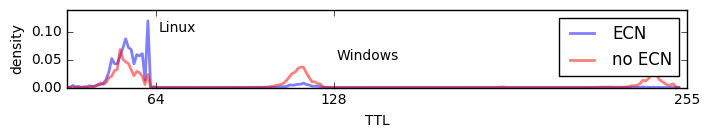

In [18]:
# Negotiation TTL spectrum
def ttl_spectrum(df, col):
    grp = df.groupby(np.digitize(df[col], np.linspace(0,255,256)))
    ser = grp[col].count() / len(df)
    ser.index = ser.index + (-1)
    return ser

ettl = ttl_spectrum(qq_df_ecn,"ams-0-ttl")
nttl = ttl_spectrum(qq_df_noecn,"ams-0-ttl")

plt.figure(figsize=(8,1))
plt.plot(ettl.index, ettl, c="b", lw=2, alpha=0.50, label="ECN")
plt.plot(nttl.index, nttl, c="r", lw=2, alpha=0.50, label="no ECN")
plt.annotate("Linux", xy=(65,0.1))
plt.annotate("Windows", xy=(129,0.05))
plt.legend()
plt.xlim(32,255)
plt.yticks([0,0.05,0.1])
plt.xticks([64,128,255])
plt.ylabel("density")
plt.xlabel("TTL")
plt.savefig(PLOTSDIR+"/negottl.pdf", bbox_inches="tight")